# Parking Availability

## Data
Data set contains:
 - timestamps when a parking session was started and finished: `START_TIME` and `END_TIME`
 - GPS coordinates of the location where a vehicle was parked: `Lon` and `Lat`

In [327]:
from bokeh.io import output_notebook, show
from bokeh.models import (GMapOptions, ColumnDataSource)
from bokeh.models.glyphs import Text
from bokeh.plotting import gmap

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import itertools

In [328]:
area_title = 'IJburg'
file_name_prefix = area_title.lower() + '_'
area_lat = 52.355
area_lon = 5
area_zoom = 14

restrict_initial_data_to = -1 #100000

v_area_split_by = 5 #11
h_area_split_by = 5 #11

downsampling_interval_in_minutes = 60

enforcement_start = 8
enforcement_end = 23
no_enforcement_weekdays = [6]

limit_by_spots = 5

GOOGLE_API_KEY = ''
with open('google_api.key', 'r') as myfile:
    GOOGLE_API_KEY = myfile.read()

In [329]:
class DataSetCleaner(object):
    def __init__(self, start_time, end_time, ignore_weekdays=None):
        self._start_time = start_time
        self._end_time = end_time
        self._ignore_weekdays = ignore_weekdays
        
        if self._ignore_weekdays == None:
            self._ignore_weekdays = []
        
    def cleanup(self, df, start_time_column, stop_time_column, inplace=False):
        to_drop = df[(df[start_time_column].dt.hour < self._start_time) | (df[stop_time_column].dt.hour > self._end_time) | (df[start_time_column].dt.dayofweek.isin(self._ignore_weekdays))].index
        
        if inplace:
            df.drop(to_drop, inplace=inplace)
        else:
            return df.drop(to_drop, inplace=inplace)

In [330]:
df = pd.read_csv('ijburg2017april_sep2.csv')
df.head()

START_TIME                STOP_TIME       Lon        Lat
0  2017-09-30 21:40:00.250  2017-09-30 21:40:08.593  4.990345  52.358908
1  2017-09-30 20:25:02.600  2017-09-30 20:25:32.710  5.007608  52.350011
2  2017-09-30 19:15:51.303  2017-09-30 19:17:02.013  5.015789  52.354633
3  2017-09-30 19:06:02.730  2017-09-30 20:23:53.023  4.993960  52.354604
4  2017-09-30 18:46:00.973  2017-09-30 22:21:13.130  4.994605  52.357612

Cast timestamps to the propper type.

In [331]:
df.START_TIME = pd.to_datetime(df.START_TIME)
df.STOP_TIME = pd.to_datetime(df.STOP_TIME)
df.dtypes

START_TIME    datetime64[ns]
STOP_TIME     datetime64[ns]
Lon                  float64
Lat                  float64
dtype: object

In [332]:
ds_cleaner = DataSetCleaner(enforcement_start, enforcement_end, ignore_weekdays=no_enforcement_weekdays)

print('{0} - size of df before dropping rows'.format(len(df)))
ds_cleaner.cleanup(df, 'START_TIME', 'STOP_TIME', inplace=True)
print('{0} - size of df before dropping rows'.format(len(df)))

120400 - size of df before dropping rows
99933 - size of df before dropping rows


Restrict the dataset. Data volumes of big size cannot be handled on the later steps.

In [333]:
if restrict_initial_data_to > -1:
    df = df.head(restrict_initial_data_to)

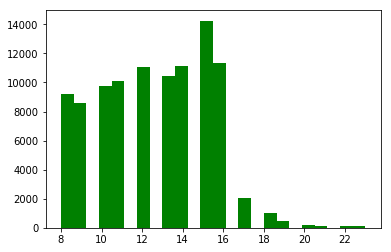

In [334]:
n, bins, patches = plt.hist(df['START_TIME'].dt.hour.values, 24, facecolor='green')

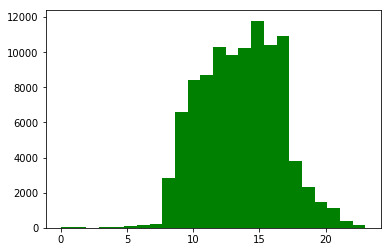

In [335]:
n, bins, patches = plt.hist(df['STOP_TIME'].dt.hour.values, 24, facecolor='green')

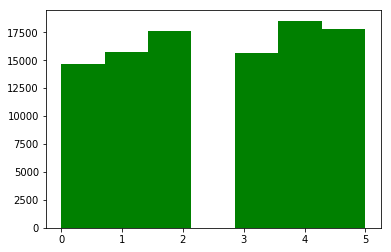

In [336]:
n, bins, patches = plt.hist(df['START_TIME'].dt.dayofweek.values, 7, facecolor='green')

## Data visualization

Let's plot the points we have on the map

In [337]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)
plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values)
)

plot.circle(x="lon", y="lat", size=1, fill_color='blue', fill_alpha=0.8, source=source)
output_notebook()

show(plot)

Loading BokehJS ...

## Area split

We don't want to predict availability for each location but for bigger zone. Let's group locations into squared areas. 

We will mark each area by its index and each pair of Lat & Lon can be mapped to the index. 

`index = lon * amount_of_cols + lat`


In [338]:
class CoordinatesMapper(object):
    def __init__(self, minLon, minLat, maxLon, maxLat, hCount = 11, vCount = 11):
        ''' Maps lat lon to a cell.
            Keyword arguments:
            minLon -- min lon in data set
            minLat -- min lat in data set
            maxLon -- max lon in data set
            maxLat -- max lat in data set
            hCount -- amount of areas horisontally
            vCount -- amount of areas vertically
        '''
        self._ndig = 3
        self._minLon = minLon
        self._minLat = minLat
        self._maxLon = maxLon
        self._maxLat = maxLat
        self._hCount = hCount
        self._vCount = vCount
        self._cell_width_lon = round((self._maxLon - self._minLon) / self._hCount, self._ndig)
        self._cell_height_lat = round((self._maxLat - self._minLat) / self._vCount, self._ndig)
        
    def toIndex(self, lon, lat):
        y = int(round(lat - self._minLat, self._ndig) / self._cell_height_lat)
        x = int((lon - self._minLon) / self._cell_width_lon)
        
        return self._hCount * y + x
    
    def getRects(self):
        dlon = self._cell_width_lon
        dlat = self._cell_height_lat
        lon_c = self._cell_width_lon / 2
        lat_c = self._cell_height_lat / 2
        
        rows = []
        
        for y in range(self._vCount+1):
            for x in range(self._hCount):
                rect = [self._minLon + x * dlon + lon_c, self._minLat + y * dlat + lat_c,  str(y * self._hCount + x) ] 
                rows.append(rect)
                
        return pd.DataFrame(rows, columns=['x', 'y', 'index'])
        

Add a new column that will hold the area index

In [339]:
mapper = CoordinatesMapper(df.Lon.min(), df.Lat.min(), df.Lon.max(), df.Lat.max(), hCount = h_area_split_by, vCount = v_area_split_by)

In [340]:
df['zone_index'] = df.apply(lambda row: mapper.toIndex(row['Lon'] ,row['Lat']), axis = 1)
print ('Area is split into {0} unique subareas'.format( df['zone_index'].nunique()))

Area is split into 31 unique subareas


## Areas visualization

Let's display the areas after the split.


In [341]:
rects = mapper.getRects()
rects

x          y index
0   4.988021  52.346639     0
1   4.994021  52.346639     1
2   5.000021  52.346639     2
3   5.006021  52.346639     3
4   5.012021  52.346639     4
5   4.988021  52.349639     5
6   4.994021  52.349639     6
7   5.000021  52.349639     7
8   5.006021  52.349639     8
9   5.012021  52.349639     9
10  4.988021  52.352639    10
11  4.994021  52.352639    11
12  5.000021  52.352639    12
13  5.006021  52.352639    13
14  5.012021  52.352639    14
15  4.988021  52.355639    15
16  4.994021  52.355639    16
17  5.000021  52.355639    17
18  5.006021  52.355639    18
19  5.012021  52.355639    19
20  4.988021  52.358639    20
21  4.994021  52.358639    21
22  5.000021  52.358639    22
23  5.006021  52.358639    23
24  5.012021  52.358639    24
25  4.988021  52.361639    25
26  4.994021  52.361639    26
27  5.000021  52.361639    27
28  5.006021  52.361639    28
29  5.012021  52.361639    29

In [342]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)

plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '00ffff', "#880977"]

points_colors = df.apply(lambda row: colors[int(row['zone_index'] % len(colors))] , axis = 1).values

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values,
        color = points_colors
    )
)

index_source = ColumnDataSource(
    data=dict(
        x=rects.x.values, 
        y=rects.y.values, 
        text=rects.index.values)
)

glyph = Text(x="x", y="y", text="text", text_color="#ffffff")

plot.circle(x="lon", y="lat", size=2, line_color='color', fill_color='color', fill_alpha=0.2, source=source)

plot.rect(x=rects.x.values, y=rects.y.values, width=650, height=520, tags=list(rects.index.values), alpha=0.5)
plot.add_glyph(index_source, glyph)

output_notebook()

show(plot)

Loading BokehJS ...

In [347]:
to_drop = df[(df.zone_index.isin([0, 1, 2, 5, 6, 10,19, 23, 24, 27,28,29,30 ]))].index
#to_drop = df[(df.zone_index.isin([25.29 ]))].index
df.drop(to_drop, inplace=True)

In [348]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)

plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '00ffff', "#880977"]

points_colors = df.apply(lambda row: colors[int(row['zone_index'] % len(colors))] , axis = 1).values

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values,
        color = points_colors
    )
)

index_source = ColumnDataSource(
    data=dict(
        x=rects.x.values, 
        y=rects.y.values, 
        text=rects.index.values)
)

glyph = Text(x="x", y="y", text="text", text_color="#ffffff")

plot.circle(x="lon", y="lat", size=2, line_color='color', fill_color='color', fill_alpha=0.2, source=source)

plot.rect(x=rects.x.values, y=rects.y.values, width=650, height=520, tags=list(rects.index.values), alpha=0.5)
plot.add_glyph(index_source, glyph)

output_notebook()

show(plot)

Loading BokehJS ...

## Downsample the time intervals

In [265]:
# The following approach is wrong.
#df['same_time_parkings'] = df.apply(lambda row:  df[(row.zone_index == df.zone_index) & (row.START_TIME < df.STOP_TIME) & (row.STOP_TIME > df.START_TIME)]['START_TIME'].count(), axis = 1)
#df.groupby('zone_index')['same_time_parkings'].max()

In [266]:
zones = df.zone_index.unique()
zones.sort()
zones

array([ 3,  4,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 25,
       26])

In [267]:
period_start = df.START_TIME.min().normalize()
period_end = df.STOP_TIME.max().normalize()

print('{0} - {1}'.format(period_start, period_end))

2017-04-01 00:00:00 - 2017-10-01 00:00:00


In [268]:
timestamps = pd.date_range(period_start, period_end, freq='{0}min'.format(downsampling_interval_in_minutes)).values
timestamps

array(['2017-04-01T00:00:00.000000000', '2017-04-01T01:00:00.000000000',
       '2017-04-01T02:00:00.000000000', ...,
       '2017-09-30T22:00:00.000000000', '2017-09-30T23:00:00.000000000',
       '2017-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [269]:
lists = [timestamps, zones]
zones_availability = pd.DataFrame(list(itertools.product(*lists)), columns=['timestamp', 'zone_index'])

print('{0} - size of df before dropping rows'.format(len(zones_availability)))
ds_cleaner.cleanup(zones_availability, 'timestamp', 'timestamp', inplace=True)
print('{0} - size of df before dropping rows'.format(len(zones_availability)))

zones_availability = zones_availability.sort_values(by=['zone_index', 'timestamp'])
zones_availability['parked'] = 0
zones_availability.head()

79074 - size of df before dropping rows
45216 - size of df before dropping rows


timestamp  zone_index  parked
144 2017-04-01 08:00:00           3       0
162 2017-04-01 09:00:00           3       0
180 2017-04-01 10:00:00           3       0
198 2017-04-01 11:00:00           3       0
216 2017-04-01 12:00:00           3       0

In [270]:
#rows = [['2017-09-30 11:02:00','2017-09-30 11:15:00',1],
#['2017-09-30 11:33:00','2017-09-30 11:54:00',1],
#['2017-09-30 12:43:00','2017-09-30 13:50:00',1],
#['2017-09-30 12:50:00','2017-09-30 12:58:00',1],
#['2017-09-30 12:56:00','2017-09-30 14:24:00',1]]
#df = pd.DataFrame(rows, columns=['START_TIME','STOP_TIME', 'zone_index'])

#df.START_TIME = pd.to_datetime(df.START_TIME)
#df.STOP_TIME = pd.to_datetime(df.STOP_TIME)
#df.dtypes

#timestamps = pd.DataFrame(pd.Series(pd.date_range('2017-09-29 00:00:00', '2017-09-30 00:00:00', freq="30min").values), columns=['timestamp'])
#zones = pd.DataFrame(pd.Series([1, 2]), columns=['zone'])
#lists = [timestamps['timestamp'].values, zones['zone'].values]
#res = pd.DataFrame(list(itertools.product(*lists)), columns=['timestamp', 'zone'])
#res.sort_values(by=['zone'])

In [271]:
def downsample_time(start, end, zone_index, minutes):
    result = []
    
    for i in range(len(ranges)-1):
        st = pd.Timestamp(start.date()) + ranges[i]
        ed = pd.Timestamp(start.date()) + ranges[i + 1]
        
        #print ('st={0}, ed={1}, -- start={2}, end={3}'.format(st, ed, start, end))
        parked = 0
        if start < ed and end > st:
            parked = 1
        
        result.append((st, parked))
    
    return result

In [272]:
ranges = pd.timedelta_range('0 days 0 hours 0 minutes', periods=(24*60)/downsampling_interval_in_minutes, freq='{0}min'.format(downsampling_interval_in_minutes))

rows = []
for i, row in df.iterrows():
    time_ranges = downsample_time(row.START_TIME, row.STOP_TIME, row.zone_index, ranges)
    #list(my_dataframe.columns.values)
    #row.values.tolist()
    for tr in time_ranges:
        rows.append([tr[0], row.zone_index, tr[1]])

In [274]:
downsampled_time_df = pd.DataFrame(rows, columns=['timestamp','zone_index', 'parked'])

print('{0} - size of df before dropping rows'.format(len(downsampled_time_df)))
ds_cleaner.cleanup(downsampled_time_df, 'timestamp', 'timestamp', inplace=True)
print('{0} - size of df after dropping rows'.format(len(downsampled_time_df)))

2296389 - size of df before dropping rows
1497645 - size of df after dropping rows


In [275]:
downsampled_time_df = pd.concat([zones_availability, downsampled_time_df])
downsampled_time_df = downsampled_time_df.groupby(['timestamp','zone_index'], as_index=False).sum()

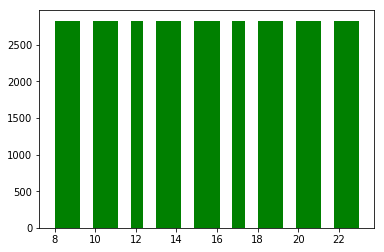

In [276]:
n, bins, patches = plt.hist(downsampled_time_df.timestamp.dt.hour.values, 24, facecolor='green')

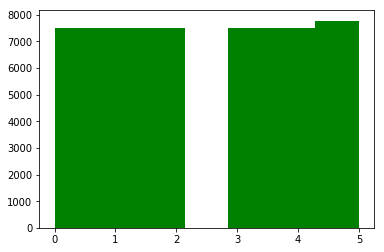

In [277]:
n, bins, patches = plt.hist(downsampled_time_df.timestamp.dt.dayofweek.values, 7, facecolor='green')

In [278]:
downsampled_time_df.describe()

zone_index        parked
count  45216.00000  45216.000000
mean      14.50000      5.115579
std        6.60184      7.279300
min        3.00000      0.000000
25%        9.00000      0.000000
50%       14.50000      2.000000
75%       20.00000      6.000000
max       26.00000     71.000000

## Save DataFrame with downsampled timestamps

In [279]:
downsampled_time_df.to_csv(file_name_prefix + 'downsampled_time.csv', index=False)

## Read DataFrame with downsampled timestamps

In [280]:
downsampled_time_df = pd.read_csv(file_name_prefix + 'downsampled_time.csv')
downsampled_time_df.timestamp = pd.to_datetime(downsampled_time_df.timestamp)
downsampled_time_df.dtypes

timestamp     datetime64[ns]
zone_index             int64
parked                 int64
dtype: object

In [281]:
len(downsampled_time_df)

45216

In [282]:
len(downsampled_time_df[downsampled_time_df.parked == 0])

12152

## Area capacity

We estimate total amount of parking spots by historical max amount of simultaniously parked cars.

In [283]:
zone_capacity = downsampled_time_df.groupby(['timestamp','zone_index'], as_index=False).sum().groupby('zone_index', as_index=False).max()
zone_capacity = zone_capacity.drop(columns=['timestamp'])
zone_capacity = zone_capacity.rename({'parked': 'spots_amount'}, axis='columns')
zone_capacity.describe()

zone_index  spots_amount
count   18.000000     18.000000
mean    14.500000     33.222222
std      6.793163     22.177242
min      3.000000      2.000000
25%      9.500000     15.500000
50%     14.500000     29.000000
75%     19.500000     51.500000
max     26.000000     71.000000

In [284]:
#zone_capacity.sort_values(by=['spots_amount','zone_index'], ascending=False)
zone_capacity

zone_index  spots_amount
0            3             9
1            4            28
2            7             8
3            8            50
4            9            67
5           11            18
6           12            66
7           13            57
8           14            71
9           15            32
10          16            27
11          17            30
12          18             2
13          20            52
14          21            36
15          22            15
16          25            17
17          26            13

In [285]:
downsampled_time_df.head()

timestamp  zone_index  parked
0 2017-04-01 08:00:00           3       1
1 2017-04-01 08:00:00           4       0
2 2017-04-01 08:00:00           7       0
3 2017-04-01 08:00:00           8       8
4 2017-04-01 08:00:00           9       3

In [286]:
parking_per_datetime=downsampled_time_df.join(zone_capacity.set_index('zone_index'),  on='zone_index',how='left' )
parking_per_datetime.head(20)

timestamp  zone_index  parked  spots_amount
0  2017-04-01 08:00:00           3       1             9
1  2017-04-01 08:00:00           4       0            28
2  2017-04-01 08:00:00           7       0             8
3  2017-04-01 08:00:00           8       8            50
4  2017-04-01 08:00:00           9       3            67
5  2017-04-01 08:00:00          11       2            18
6  2017-04-01 08:00:00          12       7            66
7  2017-04-01 08:00:00          13      15            57
8  2017-04-01 08:00:00          14       0            71
9  2017-04-01 08:00:00          15       0            32
10 2017-04-01 08:00:00          16       9            27
11 2017-04-01 08:00:00          17       5            30
12 2017-04-01 08:00:00          18       0             2
13 2017-04-01 08:00:00          20       9            52
14 2017-04-01 08:00:00          21      10            36
15 2017-04-01 08:00:00          22       1            15
16 2017-04-01 08:00:00          25       4            17
17 2017-04-01 08:00:00          26       2            13
18 2017-04-01 09:00:00           3       1             9
19 2017-04-01 09:00:00           4       1            28

In [130]:
if limit_by_spots > -1:
    parking_per_datetime = parking_per_datetime[parking_per_datetime.spots_amount >= limit_by_spots]

## Create Availability labels

For now it will be only two labels:
 - free
 - busy
 
Label is 1(busy) when ratio parked/capacity > 0.5, otherwise it is 0(free)

In [287]:
parking_per_datetime['availability'] = round((parking_per_datetime['parked'] / parking_per_datetime['spots_amount']))
parking_per_datetime.head()

timestamp  zone_index  parked  spots_amount  availability
0 2017-04-01 08:00:00           3       1             9           0.0
1 2017-04-01 08:00:00           4       0            28           0.0
2 2017-04-01 08:00:00           7       0             8           0.0
3 2017-04-01 08:00:00           8       8            50           0.0
4 2017-04-01 08:00:00           9       3            67           0.0

In [288]:
#sorteddf = parking_per_datetime.sort_values(by=['zone_index', 'timestamp'])
#sorteddf.to_csv(file_name_prefix + 'sorted.csv', index=False)

## TODO

In [289]:
parking_per_datetime.describe()

zone_index        parked  spots_amount  availability
count  45216.00000  45216.000000  45216.000000  45216.000000
mean      14.50000      5.115579     33.222222      0.047439
std        6.60184      7.279300     21.552644      0.212578
min        3.00000      0.000000      2.000000      0.000000
25%        9.00000      0.000000     15.000000      0.000000
50%       14.50000      2.000000     29.000000      0.000000
75%       20.00000      6.000000     52.000000      0.000000
max       26.00000     71.000000     71.000000      1.000000

In [290]:
zdf = parking_per_datetime
#len(zdf[zdf.spots_amount < 5])
(len(zdf[zdf.availability == 1]) / len(zdf))*100

4.743895966029724

In [291]:
zone_info = parking_per_datetime.groupby(['zone_index', 'availability'], as_index=False).count()

zone_info = zone_info.drop(columns=['parked', 'spots_amount'])
zone_info = zone_info.rename({'timestamp': 'records_count'}, axis='columns')
zone_info['1_label_count'] = zone_info['availability'] * zone_info['records_count']
zone_info['0_label_count'] = (1 - zone_info['availability']) * zone_info['records_count']
zone_info = zone_info.groupby(['zone_index'], as_index=False).max()
zone_info = zone_info.drop(columns=['availability'])
zone_info['records_count'] = zone_info['0_label_count'] + zone_info['1_label_count']

zone_info['k'] = zone_info['1_label_count'] / zone_info['records_count']
zone_info=zone_info.join(zone_capacity.set_index('zone_index'),  on='zone_index',how='left' )

zone_info = zone_info.sort_values(by=['k','1_label_count'], ascending=False)

zone_info

zone_index  records_count  1_label_count  0_label_count         k  \
10          16         2512.0          400.0         2112.0  0.159236   
13          20         2512.0          391.0         2121.0  0.155653   
7           13         2512.0          375.0         2137.0  0.149283   
17          26         2512.0          214.0         2298.0  0.085191   
14          21         2512.0          205.0         2307.0  0.081608   
16          25         2512.0          156.0         2356.0  0.062102   
0            3         2512.0          104.0         2408.0  0.041401   
6           12         2512.0           62.0         2450.0  0.024682   
2            7         2512.0           52.0         2460.0  0.020701   
5           11         2512.0           42.0         2470.0  0.016720   
8           14         2512.0           35.0         2477.0  0.013933   
15          22         2512.0           33.0         2479.0  0.013137   
3            8         2512.0           26.0         2486.0  0.010350   
4            9         2512.0           16.0         2496.0  0.006369   
9           15         2512.0           15.0         2497.0  0.005971   
12          18         2512.0            9.0         2503.0  0.003583   
1            4         2512.0            7.0         2505.0  0.002787   
11          17         2512.0            3.0         2509.0  0.001194   

    spots_amount  
10            27  
13            52  
7             57  
17            13  
14            36  
16            17  
0              9  
6             66  
2              8  
5             18  
8             71  
15            15  
3             50  
4             67  
9             32  
12             2  
1             28  
11            30

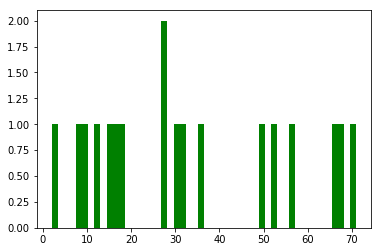

In [292]:
mu, sigma = 100, 15
x = zone_info.spots_amount.values

# the histogram of the data
n, bins, patches = plt.hist(x, 50, facecolor='green')

## Extract more features

In [293]:
weekdays = parking_per_datetime.timestamp.dt.weekday
parking_per_datetime = parking_per_datetime.assign(weekday = weekdays)
parking_per_datetime = parking_per_datetime.assign(hour = parking_per_datetime.timestamp.dt.hour)

In [294]:
dummies = pd.get_dummies(parking_per_datetime, columns=['zone_index','weekday', 'hour'])
dummies.columns

Index(['timestamp', 'parked', 'spots_amount', 'availability', 'zone_index_3',
       'zone_index_4', 'zone_index_7', 'zone_index_8', 'zone_index_9',
       'zone_index_11', 'zone_index_12', 'zone_index_13', 'zone_index_14',
       'zone_index_15', 'zone_index_16', 'zone_index_17', 'zone_index_18',
       'zone_index_20', 'zone_index_21', 'zone_index_22', 'zone_index_25',
       'zone_index_26', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [295]:
dummies.sort_values(by=['timestamp'], inplace=True)
dummies.drop(columns=['timestamp', 'parked', 'spots_amount',], inplace=True)

## Train a model

In [296]:
training_size = int(len(dummies) * 0.7)
validation_size = int(len(dummies) * 0.15)
test_size = len(dummies) - training_size - validation_size

In [298]:
X_train = dummies.head(training_size)
y_train = X_train['availability']
X_train.drop(columns=['availability'], inplace=True)

In [299]:
validate_and_test = dummies.tail(validation_size + test_size)

In [300]:
X_validate = validate_and_test.head(validation_size)
y_validate = X_validate['availability']
X_validate.drop(columns=['availability'], inplace=True)

In [301]:
X_test = validate_and_test.tail(test_size)
y_test = X_test['availability']
X_test.drop(columns=['availability'], inplace=True)

In [309]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

lambdas = [0.00000001,0.000000011,0.000000015,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]

models = {}

for lambda_ in lambdas:
    clf = SGDClassifier(loss ='log', penalty='l1', alpha=lambda_, random_state=100).fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_validate.values)
    fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
    auc = metrics.auc(fpr, tpr)
    models[auc] = clf
    print(auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

0.509102159848
0.509102159848
0.509102159848


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

0.509102159848
0.530224807215
0.547243279746


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

0.526044389622
0.5
0.5
0.5


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [307]:
m = models[max(models.keys())]

In [308]:
fdf = pd.DataFrame(X_train.columns)
fdf['k'] = pd.Series(m.coef_[0])
fdf.sort_values(by=['k'], inplace=True)
fdf

0           k
1    zone_index_4 -396.608946
11  zone_index_17 -394.967242
38        hour_22 -391.526278
39        hour_23 -296.997447
24         hour_8 -296.411893
12  zone_index_18 -210.523055
36        hour_20 -205.511583
9   zone_index_15 -195.268793
18      weekday_0 -192.932330
34        hour_18 -180.460879
3    zone_index_8 -175.201467
19      weekday_1 -148.810610
4    zone_index_9 -126.503622
37        hour_21 -125.464094
2    zone_index_7 -111.557502
35        hour_19  -82.082676
33        hour_17  -70.495716
21      weekday_3  -33.566415
15  zone_index_22  -22.644216
20      weekday_2  -19.763627
14  zone_index_21  -15.756726
16  zone_index_25  -14.308947
5   zone_index_11   -4.050109
25         hour_9    8.433202
22      weekday_4   13.381503
23      weekday_5   15.718297
8   zone_index_14   66.969131
29        hour_13   72.630088
0    zone_index_3   89.771932
17  zone_index_26   94.954220
26        hour_10  116.957491
28        hour_12  148.842247
32        hour_16  165.823143
6   zone_index_12  188.090137
7   zone_index_13  198.867129
30        hour_14  200.240282
27        hour_11  241.776691
10  zone_index_16  282.726275
31        hour_15  327.980410
13  zone_index_20  380.332450

In [149]:
from sklearn.ensemble import RandomForestClassifier

ns = [2, 5, 10, 20, 100]

ds = [10, 20, 30, 40, 50, 60, 70]

#n = 100
#d = 2

for n in ns:
    for d in ds:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=100)
        clf.fit(X_train.values, y_train.values)
        y_pred = clf.predict(X_validate.values)
        fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
        auc = metrics.auc(fpr, tpr)
        print('n:{0} d:{1} = auc:{2}'.format(n,d, auc))

n:2 d:10 = auc:0.526987082509019
n:2 d:20 = auc:0.5690562085418364
n:2 d:30 = auc:0.5707882384886923
n:2 d:40 = auc:0.5707882384886923
n:2 d:50 = auc:0.5707882384886923
n:2 d:60 = auc:0.5707882384886923
n:2 d:70 = auc:0.5707882384886923
n:5 d:10 = auc:0.5175627448698553
n:5 d:20 = auc:0.5640792893440397
n:5 d:30 = auc:0.5710908103495093
n:5 d:40 = auc:0.5710908103495093
n:5 d:50 = auc:0.5710908103495093
n:5 d:60 = auc:0.5710908103495093
n:5 d:70 = auc:0.5710908103495093
n:10 d:10 = auc:0.5088191939175297
n:10 d:20 = auc:0.5625741882927965
n:10 d:30 = auc:0.5661138911517126
n:10 d:40 = auc:0.5661138911517126
n:10 d:50 = auc:0.5661138911517126
n:10 d:60 = auc:0.5661138911517126
n:10 d:70 = auc:0.5661138911517126
n:20 d:10 = auc:0.5094243376391636
n:20 d:20 = auc:0.5558652391481438
n:20 d:30 = auc:0.5614395438147329
n:20 d:40 = auc:0.5614395438147329
n:20 d:50 = auc:0.5614395438147329
n:20 d:60 = auc:0.5614395438147329
n:20 d:70 = auc:0.5614395438147329
n:100 d:10 = auc:0.5094243376391636

Random Forest doesn't outperform the previous model (which was Gradient Descent classifier). That is why we will choose the SGD classifier. We will try to add some new features.

First let's add feature interaction and see what will happen.

In [150]:
class FeatureProcessor(object):
    def add_interaction(self, df, columns):
        # collect the columns
        cols = {}

        for c in columns:
            cols[c] = []

        for dfc in df.columns:
            for c in columns:
                if dfc.startswith(c):
                    cols[c].append(dfc)

        keys = []

        for k in cols.keys():
            keys.append(k)

        new_keys = []
        self._combine(keys, 0, new_keys, cols, len(columns), [])

        for n_key in new_keys:
            n_key_name = self._to_name(n_key)
            df[n_key_name] = df.apply(lambda row: self._get_row_val(row, n_key) , axis = 1)

    def _get_row_val(self, row, n_key):
        all_ones = 1
        for nk in n_key:
            if row[nk]!=1:
                all_ones = 0
                break
        return all_ones

    def _to_name(self, key):
        return '_'.join(key)

    def _combine(self, keys, idx, res, cols, n, cur_key):

        if len(cur_key) == n:
            res.append(cur_key)

        if idx >= n:
            return

        for i in range(idx, len(keys)):
            k = keys[i]
            vals = cols[k]
            for j in range(len(vals)):
                self._combine(keys, i+1, res,cols, n, cur_key + [vals[j]])

In [151]:
dummies.columns.get_values()

array(['availability', 'zone_index_3', 'zone_index_4', 'zone_index_7',
       'zone_index_8', 'zone_index_9', 'zone_index_11', 'zone_index_12',
       'zone_index_13', 'zone_index_14', 'zone_index_15', 'zone_index_16',
       'zone_index_17', 'zone_index_20', 'zone_index_21', 'zone_index_22',
       'zone_index_25', 'zone_index_26', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22'], dtype=object)

In [152]:
#size = len(dummies)
#sample = dummies.head(100)

In [153]:
fp = FeatureProcessor()
fp.add_interaction(dummies, columns=['weekday', 'hour'])
dummies.columns.get_values()

array(['availability', 'zone_index_3', 'zone_index_4', 'zone_index_7',
       'zone_index_8', 'zone_index_9', 'zone_index_11', 'zone_index_12',
       'zone_index_13', 'zone_index_14', 'zone_index_15', 'zone_index_16',
       'zone_index_17', 'zone_index_20', 'zone_index_21', 'zone_index_22',
       'zone_index_25', 'zone_index_26', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'weekday_0_hour_6',
       'weekday_0_hour_7', 'weekday_0_hour_8', 'weekday_0_hour_9',
       'weekday_0_hour_10', 'weekday_0_hour_11', 'weekday_0_hour_12',
       'weekday_0_hour_13', 'weekday_0_hour_14', 'weekday_0_hour_15',
       'weekday_0_hour_16', 'weekday_0_hour_17', 'weekday_0_hour_18',
       'weekday_0_hour_19', 'weekday_0_hour_20', 'weekday_0_hour_21',
       'w

In [154]:
len(dummies.columns.get_values())

143

In [155]:
training_size = int(len(dummies) * 0.7)
validation_size = int(len(dummies) * 0.15)
test_size = len(dummies) - training_size - validation_size

In [157]:
X_train = dummies.head(training_size)
y_train = X_train['availability']
X_train.drop(columns=['availability'], inplace=True)

In [158]:
validate_and_test = dummies.tail(validation_size + test_size)

In [159]:
X_validate = validate_and_test.head(validation_size)
y_validate = X_validate['availability']
X_validate.drop(columns=['availability'], inplace=True)

In [160]:
X_test = validate_and_test.tail(test_size)
y_test = X_test['availability']
X_test.drop(columns=['availability'], inplace=True)

In [161]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

#lambdas = [0.00000001,0.0000001,0.00000013,0.00000015,0.00000017,0.00000019]

lambdas = [0.0000000001,0.000000005,0.00000001,0.0000001,0.000001,0.00001,0.0001]

models = {}

for lambda_ in lambdas:
    clf = SGDClassifier(loss ='log', penalty='l2', alpha=lambda_, random_state=100).fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_validate.values)
    fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
    auc = metrics.auc(fpr, tpr)
    models[auc] = clf
    print(auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.530373559874


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.56140657124


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.530373559874


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.54942588929


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.584444703053


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.53759067458


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.531721556306
